# Case Study

## Data Paper

### Data preprocessing

In [2]:
import pandas as pd
import numpy as np
import urllib.request
from io import StringIO
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import statistics
# import scipy.stats as st
import scipy.stats as stats
import matplotlib.dates as mdates
from scipy.stats import norm

import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", message="An unsupported index was provided and will be ignored when e.g. forecasting.")

In [3]:
def import_data(link):
  """ Imports the data from a certain url link

    Args:
        link (str): url to the data

    """
  with urllib.request.urlopen(link) as response:
      data = response.read().decode('utf-8')

  data = data.split("\n")
  data_list = []

  for row in data[2:-1]:
      row_list = list(filter(None, row.split(' ')))
      row_list[1] = row_list[1].rstrip('\r')
      data_list.append({'Date': row_list[0], 'Value': row_list[1]})

  df = pd.DataFrame(data_list)
  df['Date'] = pd.to_datetime(df['Date'])
  df['Value'] = df['Value'].astype(float)
  return df

In [5]:
df = import_data('https://hadleyserver.metoffice.gov.uk/hadcet/data/meantemp_daily_totals.txt')
df.head()

,Date,Value
0,1772-01-01,3.2
1,1772-01-02,2.0
2,1772-01-03,2.7
3,1772-01-04,2.7
4,1772-01-05,1.5


In [6]:
# Check for nans
print(df.isna().sum())

Date     0
Value    0
dtype: int64


In [7]:
def delete_leap_year(df):
  """ Deletes leap years from the data frame

    Args:
        df (pd.DataFrame): data frame with leap years

    Returns:
        pd.DataFrame: df without the day 02-29

    """
  df['Day'] = df['Date'].dt.day
  df['Month'] = df['Date'].dt.month
  df = df[~((df['Month'] == 2) & (df['Day'] == 29))]
  df.drop(columns=['Day', 'Month'], inplace=True)
  df.reset_index(drop=True, inplace=True)
  return df

In [8]:
df = delete_leap_year(df)
for i in df['Date']:
    if '-02-29' in str(i):
        print(i)

In [9]:
def plot_average(df, first_year, last_year):
  """ Plots the average temperature for every day over a certain time span

    Args:
        df (pd.DataFrame): df containing temperature over the years

    Returns:
        pd.DataFrame: df containing zeros and ones for a specific date

    """
  df_subset = df[(df['Date'] >= str(first_year)) & (df['Date'] < str(last_year+1))]
  df_subset['Year'] = df_subset['Date'].dt.year
  mean_per_year = df_subset.groupby('Year')['Value'].mean().reset_index()

  df_subset['Day'] = df_subset['Date'].dt.day
  df_subset['Month'] = df_subset['Date'].dt.month

  mean_by_day = df_subset.groupby(['Month', 'Day'])['Value'].mean().reset_index()

  plt.figure(figsize=(8, 4))
  plt.plot(mean_by_day['Value'])
  plt.title('Average temperature per year')
  plt.xlabel('Day of the Year')
  plt.ylabel('Temperature')
  plt.show()

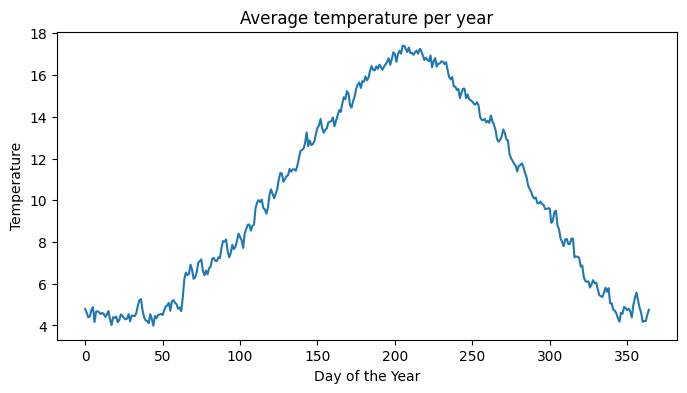

In [10]:
plot_average(df, 1980, 2020)

In [8]:
# df['DayOfYear'] = df['Date'].dt.dayofyear
# days_of_year = {day: group for day, group in df.groupby('DayOfYear')}
# df.drop(columns=['DayOfYear'], inplace=True)

In [9]:
# def get_window(date):
#     index = df.index[df['Date'] == date][0]
#     # print('Date:', str(df['Date'][index])[:10]) # , end='\r'

#     start_window = str(df['Date'][index-15])[:10]
#     end_window = str(df['Date'][index+15])[:10]
#     ts_window = df[(df['Date'] >= start_window) & (df['Date'] <= end_window)]

#     return ts_window

# get_window('1984-03-01')

### H matrix

In [11]:
def fill_matrix(df, year, day, w):
    """ Fill the matrix with ones for a specic day in a year given a certain window

    Args:
        df (pd.DataFrame): contains the matrix with zeros and ones
        year (int): the year for for which we want to fill the days with ones
        day (str): the day around we want to fill the days with ones
        w (int): the window indicates how many days we want to fill with ones
    """

    day_ind = df.columns.get_loc(day)

    # Loop throught the window
    for i in range(0, int(w/2)):
        ind_bef = day_ind - i
        ind_aft = day_ind + i

        # Handle if days exceeds year
        if ind_aft >= len(df.columns):
            year_aft = year + 1
            df.loc[year_aft, df.columns[ind_aft - len(df.columns)]] = 1
        # Set to 1 for days in given year
        elif ind_aft < len(df.columns):
          df.loc[year, df.columns[ind_aft]] = 1


        # Handle if days deceeds year
        if ind_bef < 0:
            year_bef = year - 1
            df.loc[year_bef, df.columns[ind_bef + len(df.columns)]] = 1
        # Set to 1 for days in given year
        elif ind_bef >= 0:
          df.loc[year, df.columns[ind_bef]] = 1


In [12]:
def get_matrix(first_year, last_year, day):
    """ Create a matrix containing zeros and ones for a specific block around a
    day within certain years

    Args:
        first_year (str): the first year for which we want to create a window of
        ones
        last_year (str): the last year for which we want to create a window of
        ones
        day (str): the day around we want to fill the days with ones

    Returns:
        pd.DataFrame: df containing zeros and ones for a specific date (note
        that the df contains an extra year before and after the last year)

    """

    # Create a list containing all days of a non-leap year
    days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')

    # Make a df with days as columns and years 1979-2021 as rows
    df = pd.DataFrame(0, index=range(first_year-1, last_year+2), columns=[f'{date.day}-{date.month}' for date in days_in_year])

    # Define window
    w = 30

    # Loop through the years and fill matrix with 1 ones around a specific date given a window w
    for year in range(first_year, last_year + 1):
        fill_matrix(df, year, day,w)

    return df

In [13]:
# Test matrix function

# get_matrix(1980, 2020,'16-1')
# matrix = get_matrix(1980, 2020,'31-12')
# matrix.head()

In [14]:
def get_subset_df(df, first_year, last_year):
    """ Create a subset of a dataframe given certain years

    Args:
        first_year (str): the first year included in the subset
        last_year (str): the last year included in the subset
        df (pd.DataFrame): df from which we want the subset

    Returns:
        pd.DataFrame: df containing the subset

    """

    subset = df[(df['Date'] >= str(first_year)) & (df['Date'] < str(last_year+1))]

    chunk_size = 365
    chunks = [subset[i:i+chunk_size] for i in range(0, len(subset), chunk_size)]

    df_subset = pd.DataFrame()

    for year in range(0,(last_year-first_year+1)):
        value_series = chunks[year]['Value'].reset_index(drop=True)
        columns = []

        for day in range(0, 365):
            value_for_day = value_series[day]
            column_series = pd.Series(value_for_day)
            columns.append(column_series)

        df_1_year = pd.concat(columns, axis=1)
        df_subset = pd.concat([df_subset, df_1_year], ignore_index=True)

    days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')
    df_subset.columns = [f'{date.day}-{date.month}' for date in days_in_year]
    df_subset.index = range(first_year, last_year+1)
    return df_subset

In [14]:
# df_1979_2021 = get_subset_df(df,1979, 2021)
# df_1979_2021.head()

In [15]:
# h_matrix = get_matrix(1980, 2020,'16-1')
# h_matrix.head()

In [16]:
# result = df_1979_2021*h_matrix
# result.head()

### Phi

In [15]:
def compute_phi(df, first_year, last_year):
  """ Calculate the phi for every day over a certain time period

    Args:
        first_year (str): the first year of the time period
        last_year (str): the last year of the time period
        df (pd.DataFrame): df containing the temperature

    Returns:
        list: phi_list contains the phi's for every day in the time period

    """
  days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')
  phi_list = []
  df_subset = get_subset_df(df,first_year-1, last_year+1)
  ci_upper_list = []
  ci_lower_list = []


  for date in days_in_year:
      h_matrix = get_matrix(first_year, last_year,f'{date.day}-{date.month}')
      result = df_subset*h_matrix
      y_bar = result.sum() / h_matrix.sum()
      y_bar = y_bar.fillna(0)

      numerator = []
      denominator = []
      h_list = []

      for row in range(0, ((last_year+1)-(first_year-1)+1)):
          for day in range(0, 365):

              h = h_matrix.iloc[row, day]
              y = result.iloc[row, day] - h*y_bar.iloc[day]

              if y != 0:

                if day == 0:
                    h_min1 = h_matrix.iloc[row-1, day-1]
                    y_min1 = result.iloc[row-1, day-1] - h_min1*y_bar.iloc[day-1]
                else:
                    h_min1 = h_matrix.iloc[row, day-1]
                    y_min1 = result.iloc[row, day-1] - h_min1*y_bar.iloc[day-1]

                numerator.append(y*y_min1)
                denominator.append((y_min1**2)*h*h_min1)

                h_list.append(h*h_min1)

      phi_hat = sum(numerator) / sum(denominator)
      phi_list.append(phi_hat)

      z_critical = norm.ppf(1 - 0.05 / 2)
      margin_of_error = np.sqrt((1-phi_hat**2)/sum(h_list))*z_critical

      ci_upper = phi_hat + margin_of_error
      ci_lower = phi_hat - margin_of_error
      ci_upper_list.append(ci_upper)
      ci_lower_list.append(ci_lower)


  return phi_list, ci_upper_list, ci_lower_list


In [21]:
phi_list, ci_uplist_phi, ci_lowlist_phi = compute_phi(df, 1980, 2020)

In [84]:
def plot_phi(phi_list, ci_upper_list, ci_lower_list):
  """ Plot the phi's over days in a year with confidence intervals

    Args:
        phi_list (list): the calculated phi's
        ci_upper_list (list): upper bound of CI of the phi's
        ci_lower_list (list): lower bound of CI of the phi'

    """
  days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')

  phi_df = pd.DataFrame()
  phi_df['Date'] = days_in_year
  phi_df['Mean'] = phi_list
  # phi_df['std'] = np.std(phi_list)

  # degrees_of_freedom = len(phi_list) - 1
  # margin_of_error = stats.t.ppf((1 + 0.95) / 2, degrees_of_freedom) * phi_df['std']
  phi_df['CI lower'] = ci_lower_list
  phi_df['CI upper'] = ci_upper_list

  plt.figure(figsize=(8, 4))
  plt.plot(phi_df['Date'], phi_df['Mean'], label='ϕ', linestyle='-', color='black', linewidth=1)
  plt.plot(phi_df['Date'], phi_df['CI upper'], linestyle='--', label='95% CI', color='blue', linewidth=0.5, dashes=(2, 4))
  plt.plot(phi_df['Date'], phi_df['CI lower'], linestyle='--', color='blue', linewidth=0.5, dashes=(2, 4))
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
  plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
  plt.xlim(phi_df['Date'].min(), phi_df['Date'].max())
  plt.title('Estimation results for AR(1) parameter ϕt')
  plt.xlabel('Month')
  plt.ylabel('ϕ-value')
  # plt.ylim(0.65,0.9)
  plt.legend()
  plt.show()

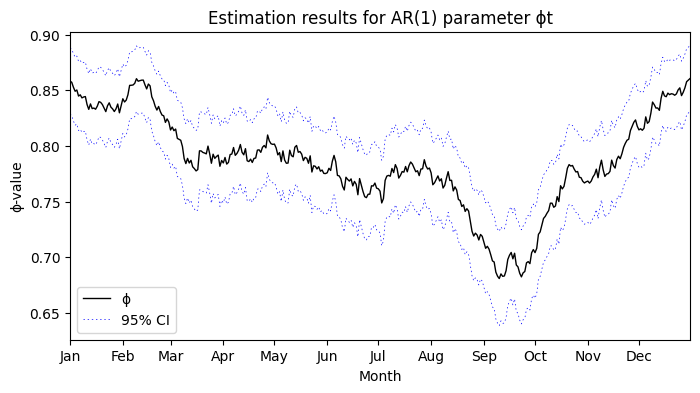

In [85]:
plot_phi(phi_list, ci_uplist_phi, ci_lowlist_phi)

### Mu

In [17]:
def compute_mu(df,first_year, last_year):
  """ Calculate the mu for every day over a certain time period

    Args:
        first_year (str): the first year of the time period
        last_year (str): the last year of the time period
        df (pd.DataFrame): df containing the temperature

    Returns:
        list: mu_list contains the mu's for every day in the time period

    """
  days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')
  mu_list = []
  df_subset = get_subset_df(df,first_year-1, last_year+1)
  # ci_lower_list = []
  # ci_upper_list = []

  for date in days_in_year:
      h_matrix = get_matrix(first_year, last_year,f'{date.day}-{date.month}')
      result = df_subset*h_matrix
      mu_series = result.sum() / h_matrix.sum()
      mu = mu_series.mean()
      mu_list.append(mu)

      # Confidence intervals
      # n = len(mu_series)
      # std = np.std(mu_series, ddof=1)
      # z_critical = norm.ppf(1 - 0.05 / 2)
      # margin_of_error = z_critical * (std / np.sqrt(n))
      # ci_lower = mu - margin_of_error
      # ci_upper = mu + margin_of_error
      # ci_lower_list.append(ci_lower)
      # ci_upper_list.append(ci_upper)
  return mu_list

In [35]:
mu_list=compute_mu(df,1980,2020)

In [70]:
def plot_mu(mu_list):
  """ Plot the mu's over days in a year

    Args:
        mu_list (list): the calculated mu's

    """
  days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')

  mu_df = pd.DataFrame()
  mu_df['Date'] = days_in_year
  mu_df['Mean'] = mu_list

  # mu_df['std'] = np.std(mu_list)
  # degrees_of_freedom = len(mu_list) - 1
  # margin_of_error = stats.t.ppf((1 + 0.95) / 2, degrees_of_freedom) * mu_df['std']
  # mu_df['CI lower'] = mu_df['Mean'] - margin_of_error
  # mu_df['CI upper'] = mu_df['Mean'] + margin_of_error

  plt.figure(figsize=(8, 4))
  plt.plot(mu_df['Date'], mu_df['Mean'], label='µ', linestyle='-', color='black', linewidth=1)
  # plt.plot(mu_df['Date'], mu_df['CI upper'], linestyle='--', label='95% CI', color='blue', linewidth=0.5, dashes=(2, 4))
  # plt.plot(mu_df['Date'], mu_df['CI lower'], linestyle='--', color='blue', linewidth=0.5, dashes=(2, 4))
  plt.axhline(0, color='red', linestyle='--', linewidth=0.5, dashes=(2, 4))
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
  plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
  plt.xlim(mu_df['Date'].min(), mu_df['Date'].max())
  # plt.ylim(-20, 30)
  plt.title('Estimation results for the local mean µt')
  plt.xlabel('Month')
  plt.ylabel('Mean Temp')
  plt.legend()
  plt.show()

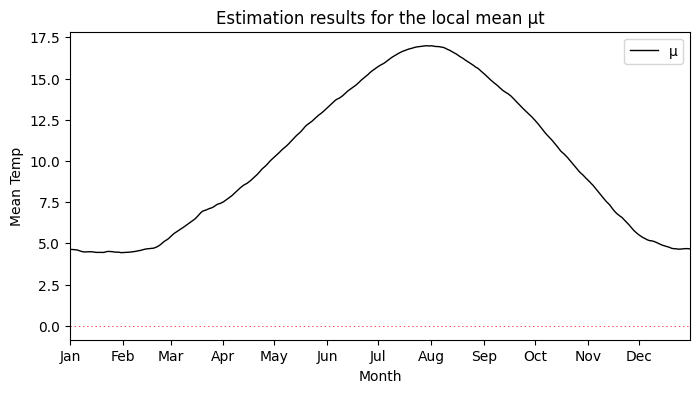

In [71]:
plot_mu(mu_list)

In [19]:
# y_flatten = y_matrix.to_numpy().flatten()
# y_flatten = y_flatten[y_flatten != 0]
# y_flatten = y_flatten.tolist()
# plt.boxplot(y_flatten)
# plt.title("y-matrix of December 31, 1980 - 2020")
# plt.ylabel("Temperature")

### Alpha

In [27]:
def compute_alpha(df, first_year, last_year, phi_list):
  """ Calculate the alpha for every day over a certain time period

    Args:
        first_year (str): the first year of the time period
        last_year (str): the last year of the time period
        df (pd.DataFrame): df containing the temperature

    Returns:
        list: alpha_list contains the alpha's for every day in the time period

    """

  days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')
  alpha_list = []
  ci_upper_list = []
  ci_lower_list = []
  df_subset = get_subset_df(df,first_year-1, last_year+1)

  for index, date in enumerate(days_in_year):
      h_matrix = get_matrix(first_year, last_year,f'{date.day}-{date.month}')
      result = df_subset*h_matrix
      day_phi = phi_list[index]

      numerator = []
      denominator = []
      y_list = []
      h_h_list = []
      h_list = []


      for year in range(0, ((last_year+1)-(first_year-1)+1)):
          for day in range(0, 365):

              h = h_matrix.iloc[year, day]
              y = result.iloc[year, day]

              if y != 0:

                if day == 0:
                    h_min1 = h_matrix.iloc[year-1, day-1]
                    y_min1 = result.iloc[year-1, day-1]
                else:
                    h_min1 = h_matrix.iloc[year, day-1]
                    y_min1 = result.iloc[year, day-1]

                numerator.append(h*h_min1*(y-day_phi*y_min1))
                denominator.append(h*h_min1)
                y_list.append(y**2)
                h_list.append(h)
                h_h_list.append(h*h_min1)


      alpha_hat = sum(numerator) / sum(denominator)
      alpha_list.append(alpha_hat)
      z_critical = norm.ppf(1 - 0.05 / 2)
      margin_of_error = np.sqrt(((sum(y_list)/sum(h_list))*(1-day_phi**2))/sum(h_h_list))*z_critical

      ci_upper = alpha_hat + margin_of_error
      ci_lower = alpha_hat - margin_of_error
      ci_upper_list.append(ci_upper)
      ci_lower_list.append(ci_lower)


  return alpha_list, ci_upper_list, ci_lower_list

In [28]:
alpha_list, ci_uplist_alpha, ci_lowlist_alpha=compute_alpha(df,1980,2020, phi_list)

In [82]:
def plot_alpha(alpha_list, ci_upper_list, ci_lower_list):
  """ Plot the alpha's over days in a year

    Args:
        alpha_list (list): the calculated alpha's
        ci_upper_list (list): upper bound of CI of the alpha's
        ci_lower_list (list): lower bound of CI of the alpha's

    """
  days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')

  alpha_df = pd.DataFrame()
  alpha_df['Date'] = days_in_year
  alpha_df['Mean'] = alpha_list

  # alpha_df['std'] = np.std(alpha_list)
  # degrees_of_freedom = len(alpha_list) - 1
  # margin_of_error = stats.t.ppf((1 + 0.95) / 2, degrees_of_freedom) * alpha_df['std']
  alpha_df['CI lower'] = ci_lower_list
  alpha_df['CI upper'] = ci_upper_list

  plt.figure(figsize=(8, 4))
  plt.plot(alpha_df['Date'], alpha_df['Mean'], label='α', linestyle='-', color='black', linewidth=1)
  plt.plot(alpha_df['Date'], alpha_df['CI upper'], linestyle='--', label='95% CI', color='blue', linewidth=0.5, dashes=(2, 4))
  plt.plot(alpha_df['Date'], alpha_df['CI lower'], linestyle='--', color='blue', linewidth=0.5, dashes=(2, 4))
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
  plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
  plt.xlim(alpha_df['Date'].min(), alpha_df['Date'].max())
  # plt.ylim(0, 5)
  plt.title('Estimation results for the intercept αt')
  plt.xlabel('Month')
  plt.ylabel('α-value')
  plt.legend()
  plt.show()

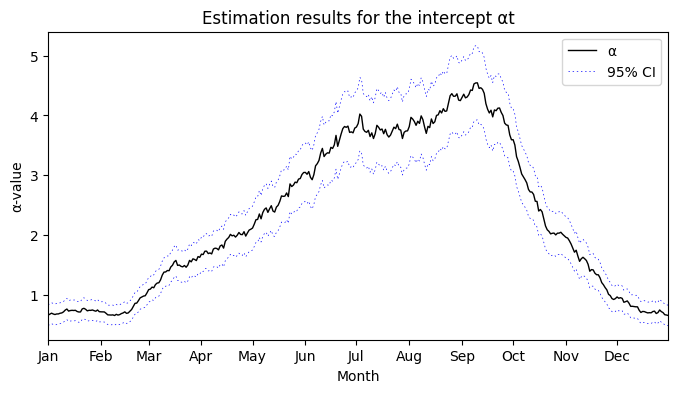

In [83]:
plot_alpha(alpha_list, ci_uplist_alpha, ci_lowlist_alpha)

### 1900-1940

In [92]:
phi_list2, ci_uplist_phi2, ci_lowlist_phi2 = compute_phi(df,1900,1940)

In [93]:
alpha_list2, ci_uplist_alpha2, ci_lowlist_alpha2 = compute_alpha(df,1900,1940,phi_list2)

In [94]:
mu_list2=compute_mu(df,1900,1940)

In [110]:
def plot_phi_2(phi_list, phi_list2, ci_uplist, ci_lowlist, ci_uplist2, ci_lowlist2):
  """ Plot the phi's from two different time periods together

    Args:
        phi_list (list): the calculated phi's of time period 1980-2020
        phi_list2 (list): the calculated phi's of time period 1900-1940

    """
  days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')
  plt.figure(figsize=(8, 4))
  plt.plot(days_in_year, phi_list, label='ϕ (1980-2020)', linestyle='-', color='red', linewidth=1)
  plt.plot(days_in_year, ci_uplist, linestyle='--', label='95% CI', color='red', linewidth=0.5, dashes=(2, 4))
  plt.plot(days_in_year, ci_lowlist, linestyle='--', color='red', linewidth=0.5, dashes=(2, 4))

  plt.plot(days_in_year, phi_list2, label='ϕ (1900-1940)', linestyle='-', color='blue', linewidth=1)
  plt.plot(days_in_year, ci_uplist2, linestyle='--', label='95% CI', color='blue', linewidth=0.5, dashes=(2, 4))
  plt.plot(days_in_year, ci_lowlist2, linestyle='--', color='blue', linewidth=0.5, dashes=(2, 4))

  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
  plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
  plt.xlim(days_in_year.min(), days_in_year.max())
  # plt.ylim(0, 5)
  plt.title('Estimation results for AR(1) parameter ϕt')
  plt.xlabel('Month')
  plt.ylabel('ϕ-value')
  plt.legend()
  plt.show()

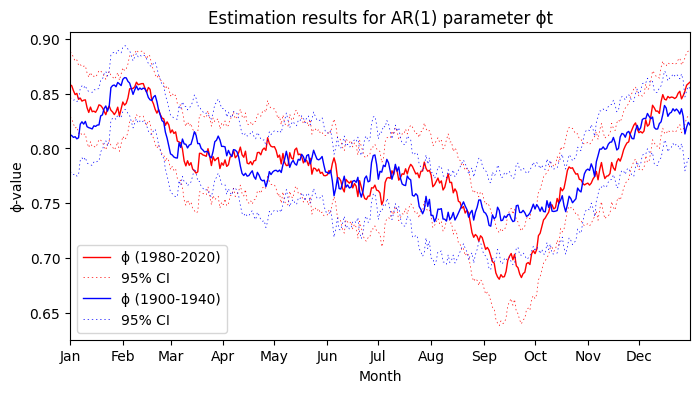

<Figure size 640x480 with 0 Axes>

In [96]:
plot_phi_2(phi_list, phi_list2, ci_uplist_phi, ci_lowlist_phi, ci_uplist_phi2, ci_lowlist_phi2)
# plt.savefig('cet_phi.png') #werkt nog ni

In [111]:
def plot_mu_2(mu_list, mu_list2):
  """ Plot the mu's from two different time periods together

    Args:
        mu_list (list): the calculated mu's of time period 1980-2020
        mu_list2 (list): the calculated mu's of time period 1900-1940

    """
  days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')
  plt.figure(figsize=(8, 4))
  plt.plot(days_in_year, mu_list, label='µ (1980-2020)', linestyle='-', color='red', linewidth=1)
  plt.plot(days_in_year, mu_list2, label='µ (1900-1940)', linestyle='-', color='blue', linewidth=1)
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
  plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
  plt.xlim(days_in_year.min(), days_in_year.max())
  # plt.ylim(0, 20)
  plt.title('Estimation results for the local mean µt')
  plt.xlabel('Month')
  plt.ylabel('Mean Temp')
  plt.legend()
  plt.show()

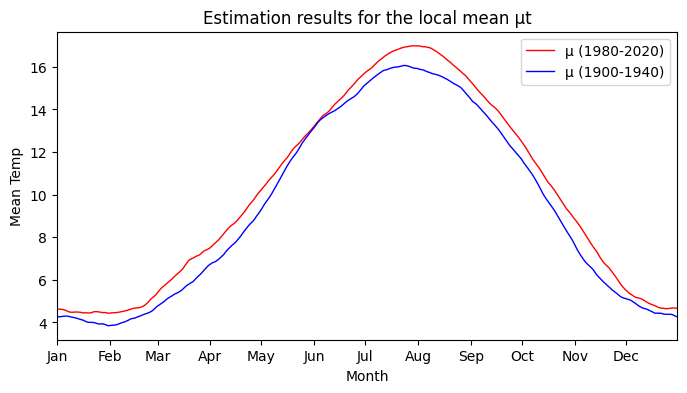

<Figure size 640x480 with 0 Axes>

In [98]:
plot_mu_2(mu_list, mu_list2)
# plt.savefig('cet_mu.png') #werkt nog ni

In [112]:
def plot_alpha_2(alpha_list, alpha_list2, ci_uplist, ci_lowlist, ci_uplist2, ci_lowlist2):
  """ Plot the alpha's from two different time periods together

    Args:
        alpha_list (list): the calculated alpha's of time period 1980-2020
        alpha_list2 (list): the calculated alpha's of time period 1900-1940

    """
  days_in_year = pd.date_range(start=f'1/1/{2023}', end=f'12/31/{2023}', freq='D')
  plt.figure(figsize=(8, 4))
  plt.plot(days_in_year, alpha_list, label='α (1980-2020)', linestyle='-', color='red', linewidth=1)
  plt.plot(days_in_year, ci_uplist, linestyle='--', label='95% CI', color='red', linewidth=0.5, dashes=(2, 4))
  plt.plot(days_in_year, ci_lowlist, linestyle='--', color='red', linewidth=0.5, dashes=(2, 4))

  plt.plot(days_in_year, alpha_list2, label='α (1900-1940)', linestyle='-', color='blue', linewidth=1)
  plt.plot(days_in_year, ci_uplist2, linestyle='--', label='95% CI', color='blue', linewidth=0.5, dashes=(2, 4))
  plt.plot(days_in_year, ci_lowlist2, linestyle='--', color='blue', linewidth=0.5, dashes=(2, 4))

  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
  plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
  plt.xlim(days_in_year.min(), days_in_year.max())
  # plt.ylim(0, 5)
  plt.title('Estimation results for the intercept αt')
  plt.xlabel('Month')
  plt.ylabel('α-value')
  plt.legend()
  plt.show()

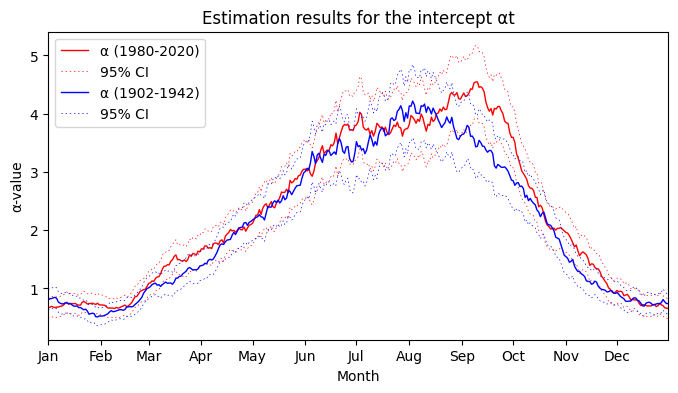

<Figure size 640x480 with 0 Axes>

In [116]:
plot_alpha_2(alpha_list, alpha_list2, ci_uplist_alpha, ci_lowlist_alpha, ci_uplist_alpha2, ci_lowlist_alpha2)
# plt.savefig('cet_alpha.png') #werkt nog ni

## New data

### Import data

In [101]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [102]:
def read_data(path):
  # Df file
  df = pd.read_csv(path, skiprows=20, delimiter = ',', na_values='-9999')

  # Remove whitespaces from column names
  df.columns = df.columns.str.replace(' ', '')

  # Select interesting columns
  df = df[['DATE', 'TG']]

  # Convert DATE to datetime
  df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')

  # Get temperature
  df['TG'] = df['TG'].apply(lambda x: int(x) / 10 if pd.notna(x) else x)

  # Rename columns to use functions earlier
  df = df.rename(columns={'DATE': 'Date', 'TG': 'Value'})

  # Delete leap years
  df = delete_leap_year(df)

  # Impute missing values (linear as that makes sense for temperatures?)
  df['Value'] = df['Value'].interpolate(method='linear')

  return df

In [103]:
df_dublin = read_data('/content/drive/MyDrive/CaseStudy/dublin.txt')
df_bilt = read_data('/content/drive/MyDrive/CaseStudy/bilt.txt')
df_marseille = read_data('/content/drive/MyDrive/CaseStudy/marseille.txt')

In [105]:
df_stockholm = read_data('/content/drive/MyDrive/CaseStudy/stockholm.txt')
df_wenen = read_data('/content/drive/MyDrive/CaseStudy/wenen.txt')
df_praag = read_data('/content/drive/MyDrive/CaseStudy/praag.txt')
df_talinn = read_data('/content/drive/MyDrive/CaseStudy/tallinn.txt')

### Bilt

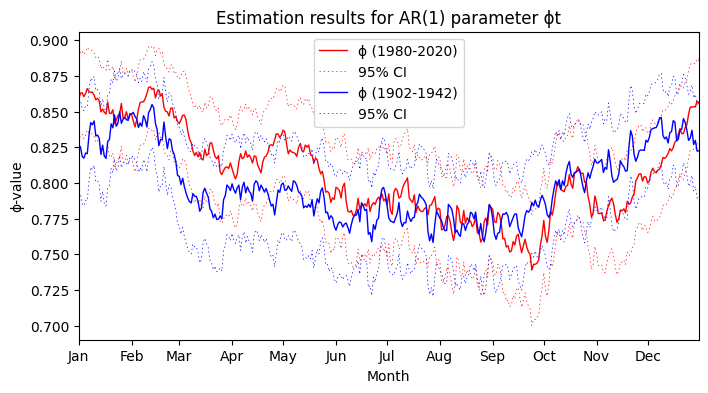

<Figure size 640x480 with 0 Axes>

In [113]:
phi_list_bilt, ci_uplist_phi_bilt, ci_lowlist_phi_bilt = compute_phi(df_bilt,1980,2020)
phi_list2_bilt, ci_uplist_phi2_bilt, ci_lowlist_phi2_bilt = compute_phi(df_bilt,1902,1942) # dataset is from 1901, change labels manually in function
plot_phi_2(phi_list_bilt, phi_list2_bilt, ci_uplist_phi_bilt, ci_lowlist_phi_bilt, ci_uplist_phi2_bilt, ci_lowlist_phi2_bilt)
# plt.savefig('bilt_phi.png') #werkt nog ni

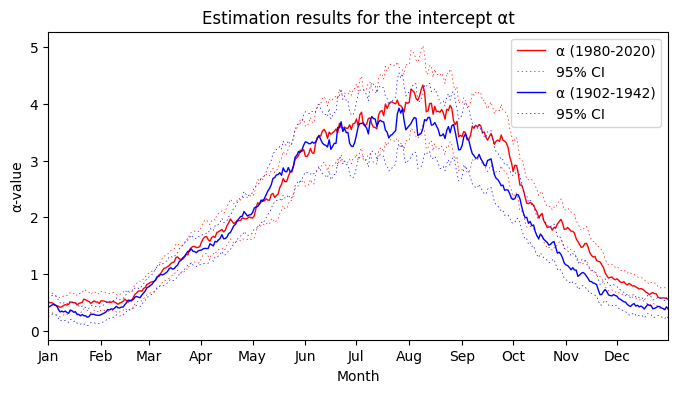

<Figure size 640x480 with 0 Axes>

In [114]:
alpha_list_bilt, ci_uplist_alpha_bilt, ci_lowlist_alpha_bilt = compute_alpha(df_bilt,1980,2020,phi_list_bilt)
alpha_list2_bilt, ci_uplist_alpha2_bilt, ci_lowlist_alpha2_bilt = compute_alpha(df_bilt,1902,1942,phi_list2_bilt) # dataset is from 1901, change labels manually in function
plot_alpha_2(alpha_list_bilt, alpha_list2_bilt, ci_uplist_alpha_bilt, ci_lowlist_alpha_bilt, ci_uplist_alpha2_bilt, ci_lowlist_alpha2_bilt)
# plt.savefig('bilt_alpha.png') #werkt nog ni

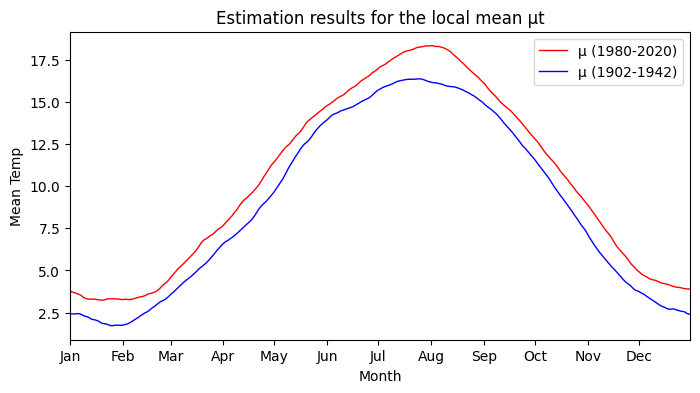

<Figure size 640x480 with 0 Axes>

In [115]:
mu_list_bilt=compute_mu(df_bilt,1980,2020)
mu_list2_bilt=compute_mu(df_bilt,1902,1942) # dataset is from 1901, change labels manually in function
plot_mu_2(mu_list_bilt, mu_list2_bilt)
# plt.savefig('bilt_mu.png') #werkt nog ni